In [1]:
import glob
import os
import librosa
from librosa import display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
%matplotlib inline
plt.style.use('ggplot')


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [2]:
features = np.loadtxt('nn_simple_features.csv', delimiter=',')
labels = np.array(np.loadtxt('nn_simple_labels.csv', delimiter=','), dtype=np.int)

In [3]:
from sklearn.preprocessing import normalize

X_all = features
y_all = labels

In [4]:
from sklearn.model_selection import train_test_split
import time

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, stratify=y_all, train_size=.85, random_state=round(time.time()))

# X_train, X_val, y_train, y_val = train_test_split(
#     X_not_test, y_not_rest, stratify=y_not_rest, train_size=.9, random_state=round(time.time()))

print(X_train.shape)
print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(10052, 1280)
(10052, 5)
(1774, 1280)
(1774, 5)


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
# Parameters
# learning_rate = 0.005

with tf.name_scope("learning_rate"):
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.005
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                               75, 0.99, staircase=True)
    tf.summary.scalar("learning_rate", learning_rate)

epochs = 40
batch_size = 32

# Network Parameters
n_input = 40 * 32
n_classes = 5
dropout = .8 # Dropout, probability to keep units

# 1. Define Variables and Placeholders
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

def build_model(x, dropout, activation):
    
    x = tf.reshape(x, shape=[-1, 40, 32, 1])
    
    conv1 = tf.layers.conv2d(x, 4, 5, activation=activation)
    conv1 = tf.layers.batch_normalization(conv1)
    conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
    conv1 = tf.nn.dropout(conv1, dropout)
    
    conv2 = tf.layers.conv2d(conv1, 8, 3, activation=activation)
    conv2 = tf.layers.batch_normalization(conv2)
    conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
    conv2 = tf.nn.dropout(conv2, dropout)
    
    fc1 = tf.contrib.layers.flatten(conv2)

    fc1 = tf.layers.dense(fc1, 128, activation=activation)
    fc1 = tf.layers.batch_normalization(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    fc2 = tf.layers.dense(fc1, 64, activation=activation)
    fc2 = tf.layers.batch_normalization(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    
    out = tf.layers.dense(fc2, n_classes)

    return out

predictions = build_model(x, keep_prob, activation=tf.nn.relu)
# 3. Define the loss function
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y), name='loss')
    tf.summary.scalar("loss", loss)
    

# 4. Define the accuracy 
with tf.name_scope("accuracy"):
    correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    tf.summary.scalar("accuracy", accuracy)

summary = tf.summary.merge_all()
# 5. Define an optimizer
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss, global_step=global_step)

def feed_next_batch(train_size, batch_size=64):
    
    start = 0
    while start < train_size:
        yield start, start + batch_size
        start += batch_size

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

RUN_NAME = 'batch_size_32_0.005_starting_lr'
writer_train = tf.summary.FileWriter('./log/' + RUN_NAME + '/train', graph=sess.graph)
writer_test = tf.summary.FileWriter('./log/' + RUN_NAME + '/test', graph=sess.graph)

steps = 0
# Keep training until reach max iterations
for epoch in range(epochs):

    indices = np.arange(len(y_train))
    np.random.shuffle(indices)
    X_train, y_train =  X_train[indices], y_train[indices]

    for start, end in feed_next_batch(len(X_train), batch_size=batch_size):
        # Run optimization op (backprop)
        batch_x, batch_y = X_train[start:end], y_train[start:end]
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
        
#         steps += 1
        
#     if steps % 20 == 0:

    # Calculate batch loss and accuracy
    train_loss, train_acc, train_lr, summary_train = sess.run([loss, accuracy, learning_rate, summary], 
                                           feed_dict={x: X_train, y: y_train, keep_prob: 1.0})
    writer_train.add_summary(summary_train, epoch + 1)

    print('Epoch %d' % (epoch + 1))
    print('learning_rate:', train_lr)
    print ("Training loss:", train_loss, ', Training acc: ', train_acc)

    val_loss, val_acc, summary_test = sess.run([loss, accuracy, summary], feed_dict={x: X_test, 
                                                                y: y_test,
                                                               keep_prob: 1.0})
    writer_test.add_summary(summary_test, epoch + 1)
    print ("Test loss:", val_loss, ', Test acc: ', val_acc)
    print('-' * 80)

print ("Optimization Finished!")

# Calculate accuracy for all test samples
print ("Training Accuracy:", \
    sess.run(accuracy, feed_dict={x: X_train,
                                  y: y_train,
                                 keep_prob: 1.0}))
print ("Test Accuracy:", \
    sess.run(accuracy, feed_dict={x: X_test,
                                  y: y_test,
                                 keep_prob: 1.0}))

Epoch 1
learning_rate: 0.00480298
Training loss: 1.40081 , Training acc:  0.397135
Test loss: 1.40481 , Test acc:  0.40699
--------------------------------------------------------------------------------
Epoch 2
learning_rate: 0.00461372
Training loss: 1.09444 , Training acc:  0.56148
Test loss: 1.11654 , Test acc:  0.553551
--------------------------------------------------------------------------------
Epoch 3
learning_rate: 0.00443192
Training loss: 0.803566 , Training acc:  0.695782
Test loss: 0.843929 , Test acc:  0.665727
--------------------------------------------------------------------------------
Epoch 4
learning_rate: 0.00425729
Training loss: 0.703142 , Training acc:  0.739057
Test loss: 0.756601 , Test acc:  0.713641
--------------------------------------------------------------------------------
Epoch 5
learning_rate: 0.00404864
Training loss: 0.539761 , Training acc:  0.812774
Test loss: 0.588979 , Test acc:  0.78805
-----------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


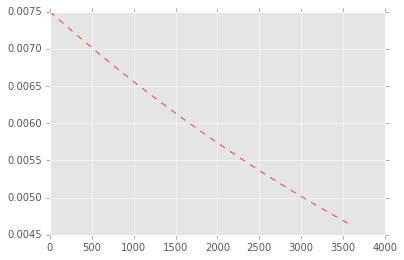

In [7]:
sess.close()

arr5 = np.arange(0, 3600)
arr5 = 0.0075 * 0.99 ** (arr5/75)
plt.plot(arr5, '--'),
plt.show()